# Assignment 4: Predictive Modeling
## version by Harry Zarcadoolas

In [1]:
!where python

C:\Users\harry\anaconda3\envs\cgs_assignment2\python.exe
C:\Users\harry\anaconda3\python.exe
C:\Program Files\Python312\python.exe
C:\Users\harry\AppData\Local\Microsoft\WindowsApps\python.exe
C:\msys64\ucrt64\bin\python.exe


### Imports

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve, auc, silhouette_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage, dendrogram
from IPython.display import display

## 1. Load expression Data

In [3]:
# load expression data
expression_data = pd.read_csv(r"C:\Users\harry\OneDrive - University of Florida\24-fall\CGS4144\assignments\bioinformatics-project\data\SRP092257\data_with_gene_names.tsv", sep='\t')

# load expression metadata 
metadata = pd.read_csv(r"C:\Users\harry\OneDrive - University of Florida\24-fall\CGS4144\assignments\bioinformatics-project\data\SRP092257\metadata_SRP092257.tsv", sep='\t')

# check size and shape of expression matrix
num_genes, num_samples = expression_data.shape
print(f"The expression matrix has {num_genes} genes and {num_samples - 1} samples.")

# check for any missing conversions (actual conversion has been done in separate conversion file)
missing_gene_names = expression_data['Gene'].isnull().sum()
print(f"There are {missing_gene_names} genes with missing names.")

The expression matrix has 23870 genes and 94 samples.
There are 0 genes with missing names.


## 2. Supervised Analysis
### a) Subset data to the 5,000 most variable genes

In [4]:
# calculate variance for each gene (don't include gene name column)
gene_variances = expression_data.drop(columns=['Gene']).var(axis=1)
# 5,000 most variable genes
top_5000_genes = expression_data.iloc[gene_variances.nlargest(5000).index]
# confirm subset data shape
print(f"Top 5000 variable gene data shape for verification: {top_5000_genes.shape}")

Top 5000 variable gene data shape for verification: (5000, 95)


### b-c) Method: Random Forest
### Data preparation and splitting data into Training (80%) and Testing (20%)

In [5]:
# map thermoneutral samples to 0 and heat affected samples to 1 for simple binary classification
metadata['condition'] = metadata['refinebio_title'].apply(
    lambda x: 0 if 'Control' in x else (1 if 'Heat' in x else np.nan)
)

# align expression data with metadata
metadata = metadata.set_index('refinebio_accession_code')
expression_data_filtered = top_5000_genes.drop(columns=['Gene']).T  # transpose data for samples as rows

# keep only samples present in metadata
expression_data_filtered = expression_data_filtered.loc[metadata.index]

# verify alignment by checking data shapes
print(f"Filtered expression data shape: {expression_data_filtered.shape}")
print(f"Filtered metadata shape: {metadata.shape}")

# define features and labels

labels = metadata['condition'].astype(int)  # ensure labels are int
# split data into 80% training and 20% testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    expression_data_filtered, labels, test_size=0.2, random_state=42
)

# confirm data sizes
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Filtered expression data shape: (94, 5000)
Filtered metadata shape: (94, 24)
Training data shape: (75, 5000)
Test data shape: (19, 5000)
Training labels shape: (75,)
Test labels shape: (19,)


### d) Predict the two groups from assignment 1 (Thermoneutral vs Heat Affected)
### Train Random Forest Model

In [6]:
# init Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# train model
rf_model.fit(X_train, y_train)

# make predictions (on test data)
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # get probabilities for Heat Affected samples (1) for AUC calculation

print("Random Forest model training complete.")


Random Forest model training complete.


### Evaluate Model

In [7]:
# classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy:.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      0.67      0.80         9

    accuracy                           0.84        19
   macro avg       0.88      0.83      0.83        19
weighted avg       0.88      0.84      0.84        19

Random Forest Model Accuracy: 0.8421


### e-f) Retrain Model with clustering (from Assignment 3)
#### First, re-use my chosen clustering method (Spectral Clustering) to produce clustering data and labels

In [8]:
# fixes warning with k-means efficiency process
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [9]:
# prepare data specifically for clustering
expression_data_for_clustering = top_5000_genes.drop(columns=['Gene']) # drop 'Gene' column

# transpose data so samples are rows and genes are columns
expression_data_for_clustering = expression_data_for_clustering.T

# verify shape
print("Data shape for Spectral Clustering:", expression_data_for_clustering.shape)

# Spectral Clustering with k=2
spectral_clustering = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
cluster_labels = spectral_clustering.fit_predict(expression_data_for_clustering)

# silhouette score to evaluate clustering quality
silhouette_avg = silhouette_score(expression_data_for_clustering, cluster_labels)
print(f"Silhouette Score for Spectral Clustering with k=2: {silhouette_avg:.4f}")

Data shape for Spectral Clustering: (94, 5000)
Silhouette Score for Spectral Clustering with k=2: 0.5447


C:\Users\harry\anaconda3\envs\cgs_assignment2\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


To reiterate, the silhouette score of 0.5447 from my best spectral clustering done in assignment 3 is a relatively low-score and may not be the best model to cluster my samples. Results from k-means and hierarchical were more practical but I still relied my chosen clustering model results, spectral, to train my Random Forest predictive model

#### Now do the retraining for the Random Trees model using the clustering labels

In [10]:
# use Spectral Clustering labels as the target variable for the clustering-based Random Forest
y_clusters_rf = cluster_labels

# use the expression data prepared for Random Forest as features
X_features_clusters = expression_data_filtered

# re-do the data split (80% training, 20% test)
X_train_clusters, X_test_clusters, y_train_clusters, y_test_clusters = train_test_split(
    X_features_clusters, y_clusters_rf, test_size=0.2, random_state=42
)

# init and train Random Forest model for clustering prediction
rf_model_clusters = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_clusters.fit(X_train_clusters, y_train_clusters)

# make predictions
y_pred_clusters = rf_model_clusters.predict(X_test_clusters)
y_pred_prob_clusters = rf_model_clusters.predict_proba(X_test_clusters)[:, 1]  # For AUC calculation

# classification report
print("Clustering Model-Based Classification Report:\n", classification_report(y_test_clusters, y_pred_clusters))

# accuracy
accuracy_clusters = accuracy_score(y_test_clusters, y_pred_clusters)
print(f"Clustering Model Accuracy: {accuracy_clusters:.4f}")

Clustering Model-Based Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.92      0.96        13

    accuracy                           0.95        19
   macro avg       0.93      0.96      0.94        19
weighted avg       0.95      0.95      0.95        19

Clustering Model Accuracy: 0.9474


## 3. Sample-specific area under the ROC curve (AUC) across the predictive models and matrix of sample labels
### AUC for Random Forest Model using gene data without clustering labels (Harry Zarcadoolas)
#### *Note: AUCs across all models calculated later*

Area Under the Curve (AUC): 0.8556


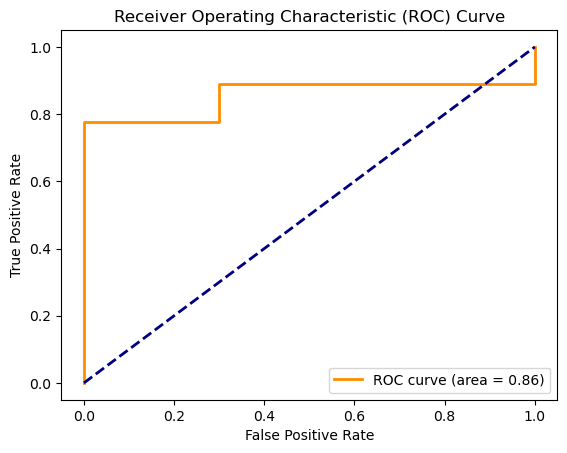

In [11]:
# calculate AUC
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"Area Under the Curve (AUC): {auc_score:.4f}")


# plot ROC curve to visualize
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


The area under the curve value scored highly for the Random Trees Model and therefore shows a strong ability to discriminate the samples effectively to categorize the samples by the target attribute, heat. The dashed diagonal line is a baseline that represents no discrimination ability, or AUC of 0.5 and the orange solid shows the specific ROC curve for my Random Forest main model. Given the high area under the curve, it can be said that the model performs strong in its ability to distinguish whether or not a sample is heat affected or thermoneutral. The graph has the y-axis showing the true positive rate (a.k.a Sensitivity or Recall), which are correctly identified as positive samples, against the x-ais showing the false positive rate (1-Specificity), which is the proportion of samples falsely identified positive samples that were actually negative. This is important because a high true positive rate coupled with a low false positive rate are associated with a strong model and that would hug the upper-left corner of the graph more. Thus, there would be more area under the curve.

### AUC for Random Forest Model using clustering labels (Harry Zarcadoolas)
#### *Since clusters are binary in my case, only 0 or 1 for clusters, I added AUC for my clustering-powered Random Forest model results*

Clustering Model AUC: 1.0000


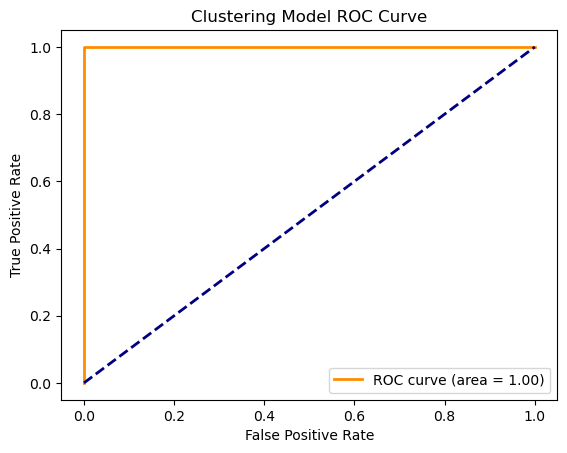

In [12]:
if len(set(y_clusters_rf)) == 2:
    auc_score_clusters = roc_auc_score(y_test_clusters, y_pred_prob_clusters)
    print(f"Clustering Model AUC: {auc_score_clusters:.4f}")

    # ROC Curve plot
    fpr_clusters, tpr_clusters, thresholds_clusters = roc_curve(y_test_clusters, y_pred_prob_clusters)
    plt.figure()
    plt.plot(fpr_clusters, tpr_clusters, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score_clusters:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Clustering Model ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

### a) Class Label Predictions per sample
### Matrix of Samples by model from each member of the team for comparison

In [13]:
y_pred_harry = y_pred  # main RF model predictions
y_pred_harry_clustering = y_pred_clusters  # clustering-based RF model predictions

# data frame where each column is a model's predictions
sample_model_matrix = pd.DataFrame({
    'Random_Forest_Model_Harry': y_pred_harry,
}, index=X_test.index)  # use the sample IDs from X_test as the index

### Teammates' model results for test samples

In [14]:
combined_predictions = pd.read_csv("combined_predictions.csv")
combined_predictions.columns = combined_predictions.columns.str.strip() # strip whitespace, if any

# sample ID column should be index in combined_predictions
combined_predictions = combined_predictions.set_index('refinebio_accession_code')

# reindex to align with the sample order in sample_model_matrix if needed
combined_predictions_aligned = combined_predictions.reindex(sample_model_matrix.index)

# add each teammate's main predictions
sample_model_matrix['Naive_Bayes_Model_Luke'] = combined_predictions_aligned['Naive_Bayes_Model_Luke'] # LUKE
sample_model_matrix['Logistic_Regression_Model_Jacob'] = combined_predictions_aligned['Logistic_Regression_Model_Jacob'] # JACOB
sample_model_matrix['K_Nearest_Model_Ryan'] = combined_predictions_aligned['K_Nearest_Model_Ryan'] # RYAN

# add true values for test samples
sample_model_matrix['True_Class_Label'] = y_test

print("NOTE: Clustering Labels are added in the following display\n")
print("KEY:\n 1 indicates Heat Affected Samples\n 0 indicates Thermoneutral - Control Samples")
# display matrix of samples
print("\nMATRIX OF SAMPLES")
display(sample_model_matrix)


NOTE: Clustering Labels are added in the following display

KEY:
 1 indicates Heat Affected Samples
 0 indicates Thermoneutral - Control Samples

MATRIX OF SAMPLES


,Random_Forest_Model_Harry,Naive_Bayes_Model_Luke,Logistic_Regression_Model_Jacob,K_Nearest_Model_Ryan,True_Class_Label
refinebio_accession_code,,,,,
SRR4478687,1,1,1,1,1
SRR4478668,1,1,1,1,1
SRR4478702,0,1,0,0,0
SRR4478720,1,0,1,0,1
SRR4478643,0,0,0,0,0
SRR4478672,0,0,0,1,1
SRR4478686,0,1,1,0,0
SRR4478715,0,0,0,1,0
SRR4478654,0,1,0,1,0


This matrix has the 19 samples that were from the 20% testing data when making the predictions on each of our respective models for predictive analysis. The remaining 75 samples were used for training and not included since they would map perfectly as they were used to actually train the models. As seen from this matrix, many of the samples identified as Heat Affected were indeed Heat Affected as shown by the True_Class_Label project. There seemed to be an overall solid and effective categorization of the samples across all models with my model, Random Forests, a little bit better than the rest in terms of accuracy.

#### b) Add clustering labels to data frame from each model to show predictions for each cluster

In [15]:
combined_cluster_predictions = pd.read_csv("combined_cluster_predictions.csv")

# Set the sample ID column as the index
combined_cluster_predictions = combined_cluster_predictions.set_index('refinebio_accession_code')

# Reindex to match the sample order in sample_model_matrix
combined_cluster_predictions_aligned = combined_cluster_predictions.reindex(sample_model_matrix.index)

# Add clustering label data
sample_model_matrix['harry_spectral_clustering'] = y_pred_harry_clustering
sample_model_matrix['jacob_hierarchical_clustering'] = combined_cluster_predictions_aligned['Hierarchical_Model_Jacob']
sample_model_matrix['ryan_k_means_clustering'] = combined_cluster_predictions_aligned[' K_Means_Model_Ryan']

print("NOTE: clustering labels do not follow key because they are just clusters from each teammate's assignment 3 clustering models\n")
print("KEY:\n 1 indicates Heat Affected Samples\n 0 indicates Thermoneutral - Control Samples")
display(sample_model_matrix)
sample_model_matrix.to_csv("sample_model_matrix_with_clustering.csv", index=True)

NOTE: clustering labels do not follow key because they are just clusters from each teammate's assignment 3 clustering models

KEY:
 1 indicates Heat Affected Samples
 0 indicates Thermoneutral - Control Samples


,Random_Forest_Model_Harry,Naive_Bayes_Model_Luke,Logistic_Regression_Model_Jacob,K_Nearest_Model_Ryan,True_Class_Label,harry_spectral_clustering,jacob_hierarchical_clustering,ryan_k_means_clustering
refinebio_accession_code,,,,,,,,
SRR4478687,1,1,1,1,1,0,1,1
SRR4478668,1,1,1,1,1,0,2,3
SRR4478702,0,1,0,0,0,1,3,2
SRR4478720,1,0,1,0,1,1,3,2
SRR4478643,0,0,0,0,0,1,3,2
SRR4478672,0,0,0,1,1,1,3,2
SRR4478686,0,1,1,0,0,0,1,1
SRR4478715,0,0,0,1,0,1,3,2
SRR4478654,0,1,0,1,0,0,1,1


This matrix of samples has appended the clustering assignments made by the predictive models of each teammate. Clustering labels from Jacob and Ryan showed 3 different possible clusters whereas my clustering only had 2 clusters. As shown from the matrix, there seemed to be widespread disparity among models. Still, my model's 0 cluster seemed to somewhat correlate with Jacob and Ryan's 1 cluster. Apart from that, each cluster seemed to be very fairly for each model. To note, Luke's model for clustering labels wasn't included yet because he was having some difficulties at the time of writing my report.

### AUC for each model

In [16]:
# dict for storing accuracy and AUC results for each model
model_performance = {}

# models to evaluate
model_columns = [
    'Random_Forest_Model_Harry', 
    'Naive_Bayes_Model_Luke', 
    'Logistic_Regression_Model_Jacob', 
    'K_Nearest_Model_Ryan'
]

# accuracy and AUC for each model
for model in model_columns:
    # accuracy
    accuracy = accuracy_score(sample_model_matrix['True_Class_Label'], sample_model_matrix[model])
    
    # AUC value
    auc = roc_auc_score(sample_model_matrix['True_Class_Label'], sample_model_matrix[model])
    
    # store results
    model_performance[model] = {'Accuracy': accuracy, 'AUC': auc}

# display with data frame
performance_df = pd.DataFrame(model_performance).T
display(performance_df)


,Accuracy,AUC
Random_Forest_Model_Harry,0.842105,0.833333
Naive_Bayes_Model_Luke,0.631579,0.627778
Logistic_Regression_Model_Jacob,0.736842,0.727778
K_Nearest_Model_Ryan,0.684211,0.677778


As shown in this table, each of the models seemed to perform relatively accurately, wiith the median around the 70% percent mark. The AUC further enforced this with values ranging from 0.62-0.83, indicating a good discrimination of the data classes. The top and worst performing models respectively were Random Forest (Harry) and Naive Bayes (Luke), with a difference in AUC of about 0.2. This could be explained by the fact that Naive Bayes takes a more simplistic approach by assuming independence of features, opposed to Random Forest which is powerful at leveraging numerous decision trees to make more complex connections while still not overfitting to data.

### c) Stability of the cluster and class label prediction correlation via Bonferroni corrected Chi-Squared statistical testing

In [17]:
# dict to store chi-squared test results for each model vs. clustering combination
chi2_results = {}
alpha = 0.05  # significance level (95% essentially)

# predicted class labels
predictive_model_columns = [
    'Random_Forest_Model_Harry', 
    'Naive_Bayes_Model_Luke', 
    'Logistic_Regression_Model_Jacob', 
    'K_Nearest_Model_Ryan'
]

#cluster labels
clustering_columns = [
    'harry_spectral_clustering', 
    'jacob_hierarchical_clustering', 
    'ryan_k_means_clustering'
]

# total tests for Bonferroni correction (multiple test correction)
num_tests = len(predictive_model_columns) * len(clustering_columns)

# loop over each combination of predictive model clustering
for model in predictive_model_columns:
    for cluster in clustering_columns:
        # ontingency table between predicted labels and cluster labels
        contingency_table = pd.crosstab(sample_model_matrix[model], sample_model_matrix[cluster])
        
        # chi-squared test
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
        
        # Bonferroni correction
        corrected_p_value = min(p_value * num_tests, 1.0)  # Ensures p-value does not exceed 1

        # store results in nested dict
        chi2_results[f"{model} vs {cluster}"] = {
            'Chi2 Statistic': chi2_stat,
            'Original P-value': p_value,
            'Corrected P-value': corrected_p_value,
            'Degrees of Freedom': dof
        }

# display results using a data frame
chi2_results_df = pd.DataFrame(chi2_results).T
display(chi2_results_df)

,Chi2 Statistic,Original P-value,Corrected P-value,Degrees of Freedom
Random_Forest_Model_Harry vs harry_spectral_clustering,1.740652,0.187056,1.000000,1.0
Random_Forest_Model_Harry vs jacob_hierarchical_clustering,4.344017,0.113949,1.000000,2.0
Random_Forest_Model_Harry vs ryan_k_means_clustering,4.344017,0.113949,1.000000,2.0
Naive_Bayes_Model_Luke vs harry_spectral_clustering,11.711140,0.000621,0.007455,1.0
Naive_Bayes_Model_Luke vs jacob_hierarchical_clustering,15.239583,0.000491,0.005888,2.0
Naive_Bayes_Model_Luke vs ryan_k_means_clustering,15.239583,0.000491,0.005888,2.0
Logistic_Regression_Model_Jacob vs harry_spectral_clustering,5.487294,0.019155,0.229862,1.0
Logistic_Regression_Model_Jacob vs jacob_hierarchical_clustering,8.586538,0.013660,0.163922,2.0
Logistic_Regression_Model_Jacob vs ryan_k_means_clustering,8.586538,0.013660,0.163922,2.0
K_Nearest_Model_Ryan vs harry_spectral_clustering,3.587408,0.058219,0.698628,1.0


c) These Chi-squared tests over the combinations of model results, including clustering-label powered results, are used to show how well cluster assignments could potentially align with predicted results from the original data and the corresponding true value. The first three rows of combinations with my Random Forest model and clustering results have statistially insignificant findings with terrible p-values. However, the next three combination with Luke's Naive Bayes shows that the model are likely highly associated with all three of the clustering results. Following this, the combinations of Jacob's Logistic Regression and Ryan's K-Nearest Model falls back into insignificant results after applying the Bonferroni Correction. These results show that the Naive Bayes model may be leveraging patterns that moreso align with the clustering structures than the other models. Altogether, the conclusion can be reached that cluster and class prediction labels do not correlate strongly across all models in general with some significance shown only from the Naive Bayes model.

## 4. Retrain predictive model using varying number of genes
### a-b) How number of genes affected results + model performance (AUC) for each of the different versions of the model

# list of gene counts to test
gene_counts = [10, 100, 1000, 10000, 5000]

# dict to store results
results = {}

# loop through each gene count
for n_genes in gene_counts:
    print(f"\nRunning Random Forest with top {n_genes} variable genes.")
    
    # select top n_genes most variable genes
    gene_variances = expression_data.drop(columns=['Gene']).var(axis=1)
    top_n_genes = expression_data.iloc[gene_variances.nlargest(n_genes).index]

    # prepare expression data
    expression_data_filtered = top_n_genes.drop(columns=['Gene']).T  # transpose for samples as rows
    expression_data_filtered = expression_data_filtered.loc[metadata.index]  # align with metadata
    
    # target feature
    labels = metadata['condition'].astype(int)

    # split into 80% training and 20% test
    X_train, X_test, y_train, y_test = train_test_split(
        expression_data_filtered, labels, test_size=0.2, random_state=42
    )

    # train Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # make predictions on test data
    y_pred = rf_model.predict(X_test)
    y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # probabilities for AUC calculation

    # performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_prob)
    
    # store resutlts
    results[n_genes] = {
        'Accuracy': accuracy,
        'AUC': auc_score
    }
    
    # display results for current gene count
    print(f"Accuracy for top {n_genes} genes: {accuracy:.4f}")
    print(f"AUC for top {n_genes} genes: {auc_score:.4f}")

# convert results to a data frame for easier comparison
results_df = pd.DataFrame(results).T
print("\nSummary of Model Performance by Gene Count:")
print(results_df)

a-b) Shown in detail above

a) From this data, it can be shown that the number of genes did indeed affect the results. The general trend was may have been logistic, with larger gene sampling producing more accurate results and a higher area under the curve (AUC). This gets tapered off around the 5000 gene mark, as the 10000 gene results slightly dipped but were still strong with an accuracy of 0.7895 and an AUC of 0.85. The sweet spot seems to be in between the 1000 and 10000 gene mark, so the fact that 5000 genes were used for most of the analysis was a good decision for producing the most wholistic predicitons.

## 5. Heatmaps and Dendrograms

<Figure size 1200x1000 with 0 Axes>

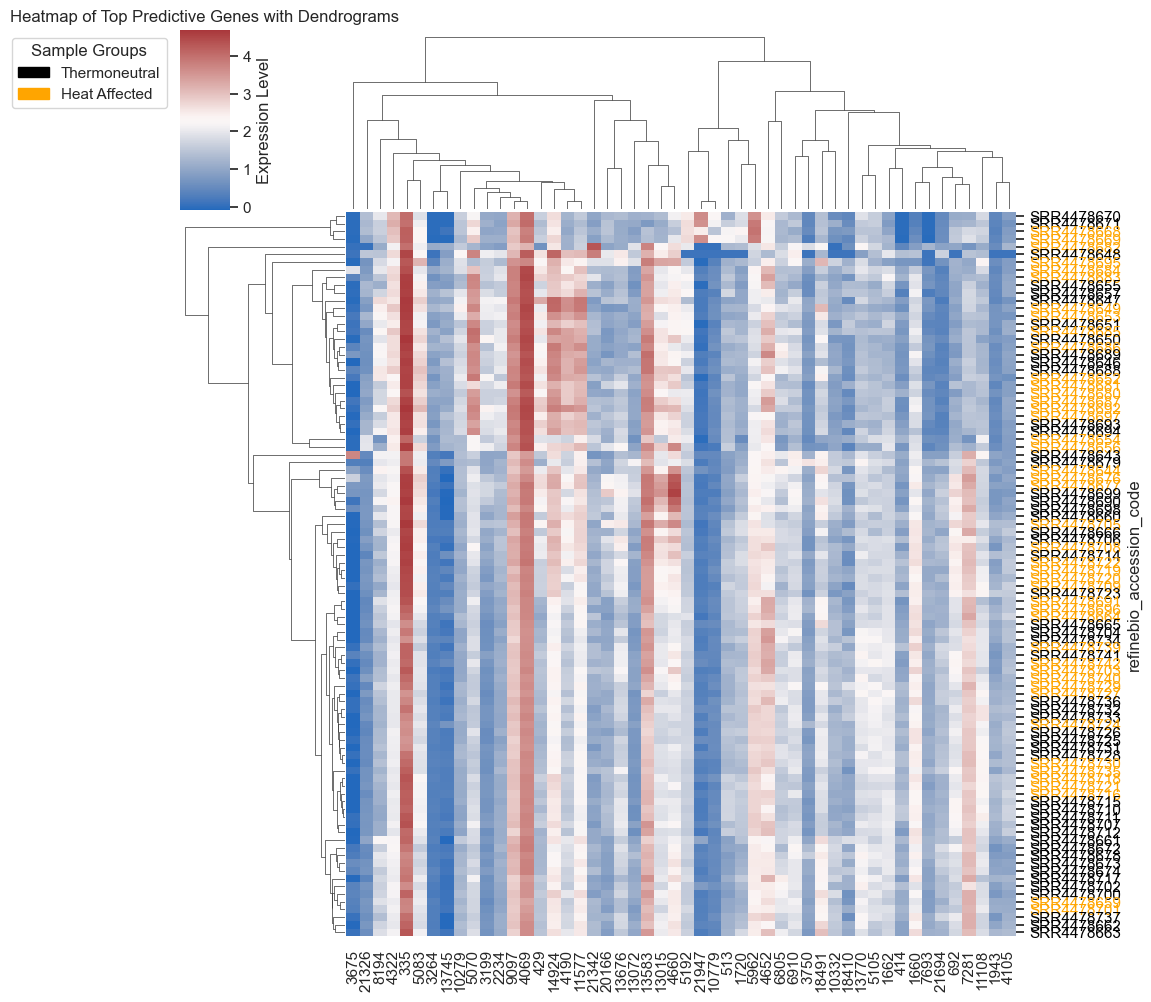

In [18]:
rf_model.fit(X_train, y_train)  # trained on 5,000 genes last used previously

# get feature importances and identify top genes
feature_importances = rf_model.feature_importances_
top_gene_indices = feature_importances.argsort()[-50:][::-1]  # use top 50 important genes for display
top_genes = expression_data_filtered.columns[top_gene_indices]

# filter expression data for those top genes only
expression_data_top_genes = expression_data_filtered[top_genes]

# add group labels to align with the heatmap annotation from the metadata
sample_groups = metadata.loc[expression_data_top_genes.index, 'condition']  # this column indicates 0 or 1

# make the heatmap with dendrograms
sns.set(style="whitegrid")

# row (sample) and column (gene) linkage matrices for dendrograms
row_linkage = linkage(expression_data_top_genes, method='average', metric='correlation')
col_linkage = linkage(expression_data_top_genes.T, method='average', metric='correlation')

# heatmap plotting
plt.figure(figsize=(12, 10))
g = sns.clustermap(
    expression_data_top_genes,
    row_cluster=True, col_cluster=True,
    row_linkage=row_linkage, col_linkage=col_linkage,
    cmap="vlag",
    xticklabels=True, yticklabels=True,
    figsize=(10, 10),
    cbar_kws={'label': 'Expression Level'}
)

# row color labels for sample groups
group_colors = sample_groups.map({0: 'black', 1: 'orange'}).values  # control = blue, heat affected = red
for tick, color in zip(g.ax_heatmap.get_yticklabels(), group_colors):
    tick.set_color(color)

# add sample group legend
from matplotlib.patches import Patch
legend_labels = [Patch(color='black', label='Thermoneutral'), Patch(color='orange', label='Heat Affected')]
plt.legend(handles=legend_labels, title='Sample Groups', bbox_to_anchor=(-3.5, 1), loc='upper left')

# display heatmap
plt.title("Heatmap of Top Predictive Genes with Dendrograms")
plt.show()

This heatmap is displaying the expression levels of some of the top predictive genes based on the Random Forests predictive analysis, which I have selected to be the top 50 genes (x-axis). They were chosen on their importance in determining the Thermoneutral vs Heat Affected samples. On the actual heatmap, blue represents low gene expression and red represents high gene expression. Also, I made the the actual samples to be coded by color, with black indicating true Thermoneutral samples and orange representing true Heat Affected samples. As seen by crossreferncing the heatmap, these top 50 genes had strong predictive power and some had varying expressions based on whether or not the chicken sample was Heat Affected or part of the control. The dendogram on the left side clusters samples based on gene expression profiles whereas the dendogram on top clusters genes based on their expression profile. Samples and clusters more similar to each other are group closely together. For genes this can suggest possible co-regulation or some kind of functional similarities. Matching these elements together, it can be seen that there is clear separation of sample groups with different target attributes, heat, showing that these groups have expression profiles of these groups can be distinguished to a high degree. This further proves that heat affected chickens do respond differently in gene expression than thermoneutral regulated chickens. Also, there are multiple co-expressed gene clusters that show consistent upregulation in Heat Affected samples and are downregulated in Thermoneutral samples.